#Install pytorch & import

In [1]:
!pip install -q http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip install torchvision

In [2]:
!pip install --upgrade torch torchvision

  Using cached https://files.pythonhosted.org/packages/49/0e/e382bcf1a6ae8225f50b99cc26effa2d4cc6d66975ccf3fa9590efcbedce/torch-0.4.1-cp36-cp36m-manylinux1_x86_64.whl
tcmalloc: large alloc 1073750016 bytes == 0x583ba000 @  0x7fe9c84732a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.2.1)
  Found existing installation: torch 0.3.0.post4
    Uninstalling torch-0.3.0.post4:
      Successfully uninstalled torch-0.3.0.post4


In [3]:
#version check
from math import sqrt
import numpy as np
from scipy import linalg
import scipy.sparse.linalg as splinalg

from time import time
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader,TensorDataset
print(torch.__version__)
use_cuda = False

0.4.1


In [4]:
if torch.cuda.is_available():
    use_cuda = True
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_cached())
    torch.cuda.empty_cache()

Tesla K80
0
0


# Define the unrolled ISTA

In [0]:
class uISTA(torch.nn.Module):

    def __init__(self, num_unroll, A, l=1., scale=1., prox=None):

        super(uISTA, self).__init__()
        self.num_unroll = num_unroll
        self.A = torch.nn.Parameter(torch.FloatTensor(A), requires_grad=True)
        self.l = torch.nn.Parameter(torch.FloatTensor([l]), requires_grad=True)
        self.scale = scale
        #self.zero = torch.FloatTensor([0])
        if prox is None:
            self.prox = lambda z, th: torch.sign(z) * torch.max(torch.sub(torch.abs(z),th), torch.zeros_like(z))
        else:
            self.prox = prox
            
    def forward(self, b):
        theta = torch.mul(self.l, self.scale)
        # prox(A.dot(b*scale), theta) for initial guess of x
        x = self.prox(torch.matmul(torch.mul(b, self.scale), self.A), theta)
        for i in range(self.num_unroll):
            # x = prox(x+A.T.dot(b-A.dot(x))*scale, theta)
            #x = self.prox(x + torch.mul(torch.matmul(torch.t(self.A), b - torch.matmul(self.A, x)), self.scale), theta)
            x = self.prox(x + torch.mul(torch.matmul(b - torch.matmul(x, torch.t(self.A)), self.A), self.scale), theta)
        return x

#Prepare datasets

In [0]:
n_samples = 400
#Generate sythetic data for demo
rng = np.random.RandomState(int(time()))
#m, n = 512, 2048
m, n = 256,512
#m, n = 2000, 4000

# use a random matrix as a basis (design matrix)
A = rng.randn(m, n) / np.sqrt(m)

# generate a k-sparse Gaussian signal vector
k = 50
stdx = 1.
snr = 10.
support_range = np.arange(0, max(int(n/4), k))

input_data = np.zeros((n_samples, m))
output_data = np.zeros((n_samples, n))
for i in range(n_samples) :

    x_true = np.zeros(n,dtype=np.float32)
    T = rng.choice(len(support_range), k, replace=False)
    x_true[support_range[T]] = rng.randn(k) * stdx

    # make the query vector
    b = A.dot(x_true)

    # add noise

    normb = linalg.norm(b)
    noise = rng.randn(m)
    noise = noise / linalg.norm(noise) * normb / snr
    tol = linalg.norm(noise)
    b = b + noise
  
    input_data[i, :] = b
    output_data[i, :] = x_true

In [0]:
n_train = min(300, n_samples)
from sklearn.model_selection import train_test_split
input_train, input_test, output_train, output_test = train_test_split(input_data, output_data, test_size=n_train)

#Demonstrate ISTA with numpy

In [0]:
# soft thresholding function
def soft(z, th):
    return np.sign(z) * np.maximum(np.abs(z) - th, 0)

from scipy import linalg
# Iterative soft thresholding (IST)
def ISTA(A, b, tol=1e-5, maxiter=300, l=1., L=None):
    m, n = A.shape
    x = np.zeros(n)
    r = b.copy()
    if L is None:    # roughly estimate the Lipschitz constant
        L = 2*linalg.norm(A.dot(A.T.dot(b))) / linalg.norm(b)
    count = 0
    cost_history = []
    normr = linalg.norm(r)
    while count < maxiter and normr > tol:
        count += 1
        x = soft(x + A.T.dot(r) / L, l/L)
        r = b - A.dot(x)
        normr = linalg.norm(r)
        cost_history.append( normr*normr + l*np.sum(np.abs(x)) )
    return x, cost_history


done 100 steps in 18.95ms by numpy
3.8238335062791116


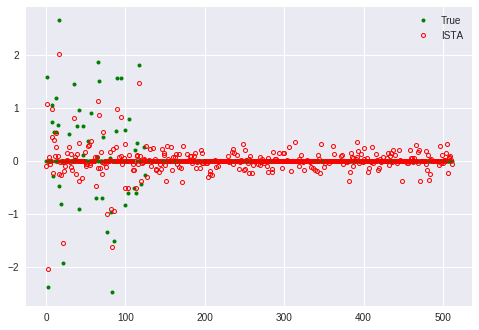

In [9]:
# pick up a test sample, and show the estimate
b = input_test[0,:]
x_true = output_test[0,:]

l = 0.1*(stdx*stdx / k * m) / np.sqrt(snr) / normb
L = 2*linalg.norm(A.dot(A.T.dot(b))) / linalg.norm(b)
maxit = 100

t0 = time()
x_est = ISTA(A, b, maxiter=maxit, l=l, L=L)[0]
print('done %d steps in %.2fms by numpy' % (maxit, (time() - t0)*1000))

print(np.linalg.norm(x_true-x_est))
import matplotlib.pyplot as plt
plt.plot(np.arange(n), x_true, 'g.', markersize=8, mec='green', label='True')
plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=4, mec='red', mew=1, label='ISTA')
plt.legend(loc='upper right', shadow=False)
plt.show()

#Instantiate model & check initial performance

In [0]:
#soft shrinkage function with learnable lambda
def softshrink(z,th):
    return torch.sign(z) * torch.max(torch.sub(torch.abs(z),th), torch.tensor(0).float().cuda())
    #return torch.sign(z) * torch.max(torch.sub(torch.abs(z),th), torch.zeros_like(z))


In [11]:
#Define NN hyper parameters and  model
n_layers_unroll  = 20

#l_ini = l
l_ini = np.ones(n)*l

if use_cuda:
    model = uISTA(n_layers_unroll, A, l=l_ini, scale=1./L, prox=lambda z,th: softshrink(z,th)).cuda()
else:
    model = uISTA(n_layers_unroll, A, l=l_ini, scale=1./L, prox=lambda z,th: softshrink(z,th))

print('Is model parameters on GPU? :', next(model.parameters()).is_cuda)

for param in model.parameters():
    print(type(param.data), param.size())
#print(model.state_dict())


Is model parameters on GPU? : True
<class 'torch.Tensor'> torch.Size([256, 512])
<class 'torch.Tensor'> torch.Size([1, 512])


done fwd. prop. of 20 layers in 18.02ms
5.131304469372348
3.8238335062791116


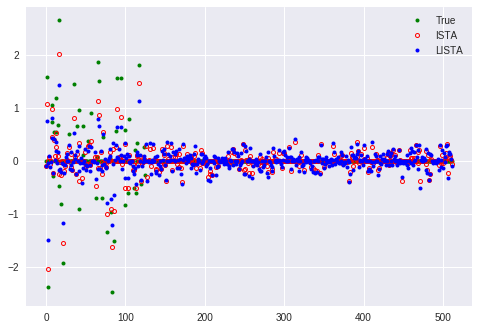

In [12]:
#print(b.shape)
#print(torch.from_numpy(b).float().size())
#print(x_est)
t0 = time()
with torch.no_grad():
    b_torch = torch.from_numpy(b).float()
    if use_cuda: b_torch = b_torch.cuda()
    model_out = model(b_torch)
print('done fwd. prop. of %d layers in %.2fms' % (model.num_unroll, (time() - t0)*1000))

x_uista = model_out.detach().cpu().numpy().ravel()
print(np.linalg.norm(x_uista-x_true))
print(np.linalg.norm(x_est-x_true))
plt.plot(np.arange(n), x_true, 'g.', markersize=8, mec='green', label='True')
plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=4, mec='red', mew=1, label='ISTA')
plt.plot(np.arange(n), x_uista, 'b.', markersize=8, mec='green', label='LISTA')
plt.legend(loc='upper right', shadow=False)
plt.show()

#Optimize the model

In [0]:
batch_size = 3

train_set = TensorDataset(torch.from_numpy(input_train).float(), torch.from_numpy(output_train).float())
data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)


#Define Loss and Optimizer
criterion = torch.nn.MSELoss()

#learning_rate = 0.0003
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

optimizer, optimizer_l, optimizer_A = None, None, None
del optimizer, optimizer_l, optimizer_A

optimizer = torch.optim.RMSprop([model.A, model.l], lr = 0.00003 * sqrt(batch_size))
#optimizer_l = torch.optim.Adam([model.l], lr = 0.03)
#optimizer_A = torch.optim.Adam([model.A], lr= 0.001)

In [14]:
#training
num_epochs = 50
display_step = 10
running_loss = 0.0

t0 = time()
for epoch in range(num_epochs):
    running_loss = 0.

    for data_in, data_out in data_loader:
        #data_in = torch.transpose(data_in, 0, 1)
        #data_out = torch.transpose(data_out, 0, 1)
        if use_cuda:
            data_in = data_in.cuda()
            data_out = data_out.cuda()

        # Forward pass
        model_out = model(data_in)
        loss = criterion(model_out, data_out)

        # Backward and optimize
        if 'optimizer' in locals():
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            running_loss += loss.item()

        if 'optimizer_A' in locals():
            optimizer_A.zero_grad()
            loss.backward(retain_graph=True)
            optimizer_A.step()
            running_loss += loss.item()

        if 'optimizer_l' in locals():
            optimizer_l.zero_grad()
            loss.backward(retain_graph=True)
            optimizer_l.step()
            running_loss += loss.item()
         
    if (epoch+1) % display_step == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss))
        print('Lambda: [{}]'.format(model.l.mean()))
print('done in %.2fs' % (time() - t0))

Epoch [10/50], Loss: 0.7988
Lambda: [0.033356621861457825]
Epoch [20/50], Loss: 0.5083
Lambda: [0.04190043359994888]
Epoch [30/50], Loss: 0.3346
Lambda: [0.049864962697029114]
Epoch [40/50], Loss: 0.2388
Lambda: [0.0572928749024868]
Epoch [50/50], Loss: 0.1843
Lambda: [0.06421271711587906]
done in 63.08s


done fwd. prop. of 20 layers in 19.87ms
3.2894347396636006
3.8238335062791116


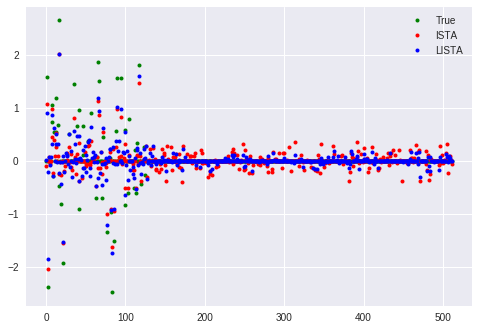

In [15]:
#model.cpu()
t0 = time()
with torch.no_grad():
    b_torch = torch.from_numpy(b).float()
    if use_cuda: b_torch = b_torch.cuda()
    model_out = model(b_torch)
print('done fwd. prop. of %d layers in %.2fms' % (model.num_unroll, (time() - t0)*1000))

x_uista = model_out.detach().cpu().numpy().ravel()
print(np.linalg.norm(x_uista-x_true))
print(np.linalg.norm(x_est-x_true))
plt.plot(np.arange(n), x_true, 'g.', markersize=8, mec='green', label='True')
plt.plot(np.arange(n), x_est, 'r.', markersize=8, mec='red', label='ISTA')
plt.plot(np.arange(n), x_uista, 'b.', markersize=8, mec='blue', label='LISTA')
#plt.plot(np.arange(n),output_init.detach().cpu().numpy(), 'bo', mfc = 'None', markersize=8, mec='blue', mew=1, label='LISTA')
plt.legend(loc='upper right', shadow=False)
plt.show()

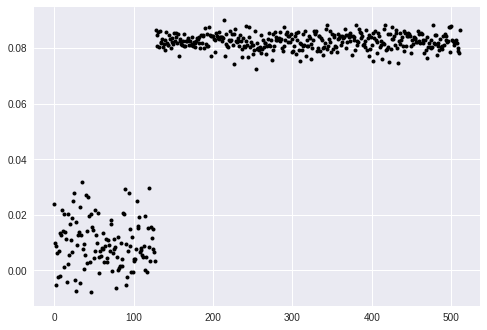

In [16]:
plt.plot(np.arange(n), model.l.detach().cpu().numpy().ravel(), 'k.', markersize=8, mec='k', label='lambda')